# Overview

This notebook scrapes information abou top selling video-games from wikipedia.

# Setup

Import all the libraries that we're going to use and load the configuration file so that we can get 

In [1]:
import json, re, os
from configparser import ConfigParser

import requests
import pandas as pd
from bs4 import BeautifulSoup

# load config
config = ConfigParser()
_ = config.read('config.ini')

# create a directory for the data
raw_data_dir = './data/raw'
os.makedirs(raw_data_dir, exist_ok=True)

# Load a wikipedia page as a BeautifulSoup object

In [2]:
def replacer(character: str, replacement: str):
    """Returns a function which replaces character with replacement."""
    def _replace(content: str):
        return content.replace(character, replacement)
    return _replace

def get_soup_from_uri(uri: str, formatter=None):
    """Loads a wikipedia page."""
    response = requests.get(uri)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.content)
    return BeautifulSoup(soup.prettify(formatter=formatter)) if formatter else soup

# load the pages
game_soup = {}
for page_title in config['Wikipedia Game Lists']:
    game_soup[page_title] = get_soup_from_uri(
        config.get('Wikipedia Game Lists', page_title),
        formatter=replacer(u'\xa0', ' ')
    )
    
    with open(f'./data/raw/{page_title}.html', 'w+', encoding='utf-8') as file:
        file.write(str(game_soup[page_title]))

In [3]:
def soup_to_dict(soup: BeautifulSoup) -> dict:
    """Convert soup from the webpage into a usable dict containing game data."""
    table = soup.find(class_='wikitable sortable')
    rows = table.select('tbody tr')

    # find the headers and rows
    headers = [str(h.get_text(strip=True)) for h in rows[0].find_all('th')]
    game_rows = rows[1:]

    # get all of the games from the rows
    games = []
    for index, row in enumerate(game_rows):
        game = {}
        for h, d in zip(headers, row.find_all('td')):
            t = d.get_text(' ', strip=True)
            if h == 'Total copies sold':
                game[h] = ' '.join(t.split()[:2])
            else:
                game[h] = t
        game['Id'] = index
        games.append(game)
    return games

games = { k: soup_to_dict(v) for k, v in game_soup.items() }

# check for non-blocking spaces
for title, page_games in games.items():
    for game in page_games:
        for k, v in game.items():
            if isinstance(k, str) and u'\xa0' in k:
                raise ValueError(f'Found in game with a non-breaking space (u"\xa0"): {json.dumps(game)}')
            if isinstance(v, str) and u'\xa0' in v:
                raise ValueError(f'Found in game with a non-breaking space (u"\xa0"): {json.dumps(game)}')
            
# write to an intermediate json file
for title, data in games.items():
    with open(f'./data/{title}.json', 'w+') as games_json:
        json.dump(data, games_json)

In [4]:
# load the pages
df_games = {}
for page_title in config['Wikipedia Game Lists']:
    # start processing the data using pandas
    with open(f'./data/{page_title}.json', 'r') as games_json:
        data = json.loads(games_json.read())
        df_games[page_title] = pd.DataFrame.from_records(data, index='Id')

In [5]:
DENOM_TO_INT = {
    'thousand': 10**3,
    'million': 10**6,
    'billion': 10**9,
    'trillion': 10**12,
}

def convert_to_int(text: str) -> int:
    try:
        n, denom = text.replace(',', '').split(' ')[:2]
        return int(float(n) * DENOM_TO_INT[denom])
    except (ValueError, KeyError):
        print(f'Unable to convert CopiesSold value "{text}" to int.')
    return None

def remove_sic(text: str) -> str:
    return re.sub(r'(?is)\[.*\]', '', text)

In [6]:
# clean up df_games_bs
df_games_bs = df_games['best_selling']
df_games_mp = df_games['most_played']

df_games_bs = df_games_bs.rename(columns={
    'Game': 'Name',
    'Total copies sold': 'CopiesSold',
    'Release date': 'Released'
})

df_games_mp = df_games_mp.rename(columns={
    'Game': 'Name',
    'Release date': 'Released',
    'Number': 'ActivePlayers',
    'Publisher(s)': 'Publisher'
})

if df_games_bs.CopiesSold.dtypes != 'int64':
    df_games_bs.CopiesSold = df_games_bs.CopiesSold.apply(convert_to_int)
    
if df_games_mp.ActivePlayers.dtypes != 'int64':
    df_games_mp.ActivePlayers = df_games_mp.ActivePlayers.apply(convert_to_int)
    
if df_games_bs.Released.dtypes != 'datetime64[ns]':
    df_games_bs.Released = pd.to_datetime(df_games_bs.Released.apply(remove_sic))
    
if df_games_mp.Released.dtypes != 'datetime64[ns]':
    df_games_mp.Released = pd.to_datetime(df_games_mp.Released.apply(remove_sic))

df_games_mp.Publisher = df_games_mp.Publisher.apply(remove_sic)

In [7]:
# write to the final CSV file
df_games_bs.to_csv(f'./data/best_selling.csv', index=False)
df_games_mp.to_csv(f'./data/most_played.csv', index=False)

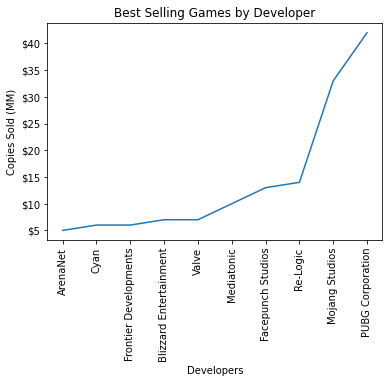

In [8]:
# explore
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

# labels
plt.title('Best Selling Games by Developer')
plt.xlabel('Developers')
plt.ylabel('Copies Sold (MM)')

# axis
plt.xticks(rotation='vertical')

formatter = ticker.FormatStrFormatter('$%.0f')
ax.yaxis.set_major_formatter(formatter)

data = df_games_bs.groupby(df_games_bs.Developer).mean().sort_values(by='CopiesSold')[-10:]
data = data.assign(Millions=lambda df: df.CopiesSold // 10 ** 6)

# graph
_ = plt.plot(data[['Millions']])

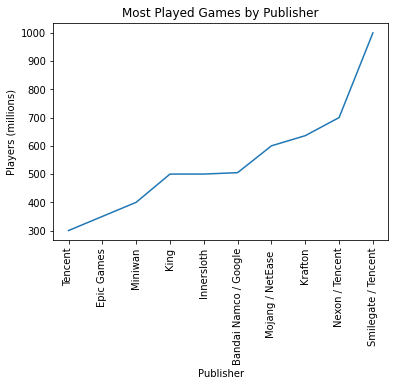

In [10]:
# explore
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

# labels
plt.title('Most Played Games by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Players (millions)')

# axis
plt.xticks(rotation='vertical')

formatter = ticker.FormatStrFormatter('%.0f')
ax.yaxis.set_major_formatter(formatter)

data = df_games_mp.groupby(df_games_mp.Publisher).mean().sort_values(by='ActivePlayers')[-10:]
data = data.assign(Millions=lambda df: df.ActivePlayers // 10 ** 6)

# graph
_ = plt.plot(data[['Millions']])